<a href="https://colab.research.google.com/github/tashir0605/NLU_Assignment/blob/main/NLU_Q_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# reading the csv file
data_path = "df_file.csv"
df = pd.read_csv(data_path)

print("Check head of data:")
print(df.head())
print("Shape:", df.shape)

#Filter Data

filtered_df = df[df["Label"].isin([0, 1])].copy()

# fixing the index after dropping rows
filtered_df = filtered_df.reset_index(drop=True)

print("New shape:", filtered_df.shape)
print("Count of each label:")
print(filtered_df["Label"].value_counts())

# mapping the numbers to names so the graph is readable later
filtered_df["Category"] = filtered_df["Label"].map({
    0: "Politics",
    1: "Sport"
})

Check head of data:
                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0
Shape: (2225, 2)
New shape: (928, 2)
Count of each label:
Label
1    511
0    417
Name: count, dtype: int64


In [9]:
#  Text Preprocessing

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# function to clean up the text
def clean_text(text):
    text = text.lower() # make everything lowercase

    # get rid of links/urls
    text = re.sub(r"http\S+", "", text)

    # remove anything that isn't a letter or space
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize (split into words)
    tokens = nltk.word_tokenize(text)

    # lemmatize and remove stop words (and short words)
    cleaned = []
    for word in tokens:
        if word not in stop_words and len(word) > 2:
            cleaned.append(lemmatizer.lemmatize(word))

    return " ".join(cleaned)

print("Cleaning text now... (this might take a moment)")
filtered_df["CleanedText"] = filtered_df["Text"].apply(clean_text)

# check  if cleaned
print("Original:", filtered_df["Text"].iloc[0][:50])
print("Cleaned :", filtered_df["CleanedText"].iloc[0][:50])

Cleaning text now... (this might take a moment)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original: Budget to set scene for election
 
 Gordon Brown w
Cleaned : budget set scene election gordon brown seek put ec


In [10]:
# 4. Vectorization (TF-IDF)
X = filtered_df["CleanedText"]
y = filtered_df["Label"]

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# limiting it to 3000 features
vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=5,
    ngram_range=(1, 2)
)


X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Train matrix shape:", X_train_vec.shape)
print("Test matrix shape :", X_test_vec.shape)

Train matrix shape: (742, 3000)
Test matrix shape : (186, 3000)


In [11]:
# Training & Comparison
print("\n--- Training Models ---")

models_to_test = {
    "Linear SVM": SVC(kernel="linear", C=1.0, random_state=42),
    "Multinomial NB": MultinomialNB(),
    "Logistic Reg": LogisticRegression(max_iter=1000)
}

comparison_results = []
trained_models = {}

# loop through the models
for name, model in models_to_test.items():
    print(f"Training {name}...")
    model.fit(X_train_vec, y_train)

    # predict on test set
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)

    print(f" -> Accuracy: {round(acc, 4)}")

    # save results for the table later
    comparison_results.append({
        "Model": name,
        "Accuracy": acc
    })
    trained_models[name] = model

# make a table to compare them
results_df = pd.DataFrame(comparison_results).sort_values(by="Accuracy", ascending=False)
print("\nFinal Leaderboard:")
print(results_df)

# Feature Importance (checking keywords for Sport vs Politics)
vocab = vectorizer.get_feature_names_out()
nb_model = trained_models["Multinomial NB"]

# sorting the probabilities
sport_top = np.argsort(nb_model.feature_log_prob_[1])[::-1]
politics_top = np.argsort(nb_model.feature_log_prob_[0])[::-1]

print("\nTop Words for SPORT:", vocab[sport_top[:10]])
print("Top Words for POLITICS:", vocab[politics_top[:10]])


--- Training Models ---
Training Linear SVM...
 -> Accuracy: 0.9946
Training Multinomial NB...
 -> Accuracy: 1.0
Training Logistic Reg...
 -> Accuracy: 0.9892

Final Leaderboard:
            Model  Accuracy
1  Multinomial NB  1.000000
0      Linear SVM  0.994624
2    Logistic Reg  0.989247

Top Words for SPORT: ['game' 'said' 'player' 'win' 'england' 'club' 'match' 'world' 'first'
 'champion']
Top Words for POLITICS: ['said' 'labour' 'party' 'election' 'blair' 'would' 'government' 'tory'
 'minister' 'brown']


/tmp/ipython-input-104689300.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")


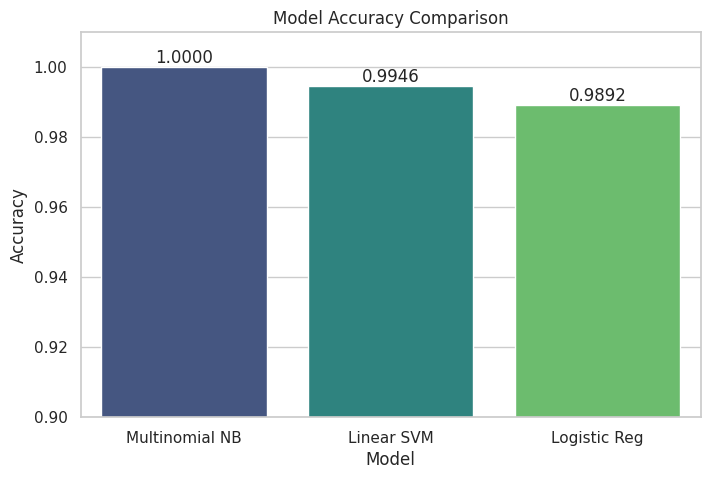

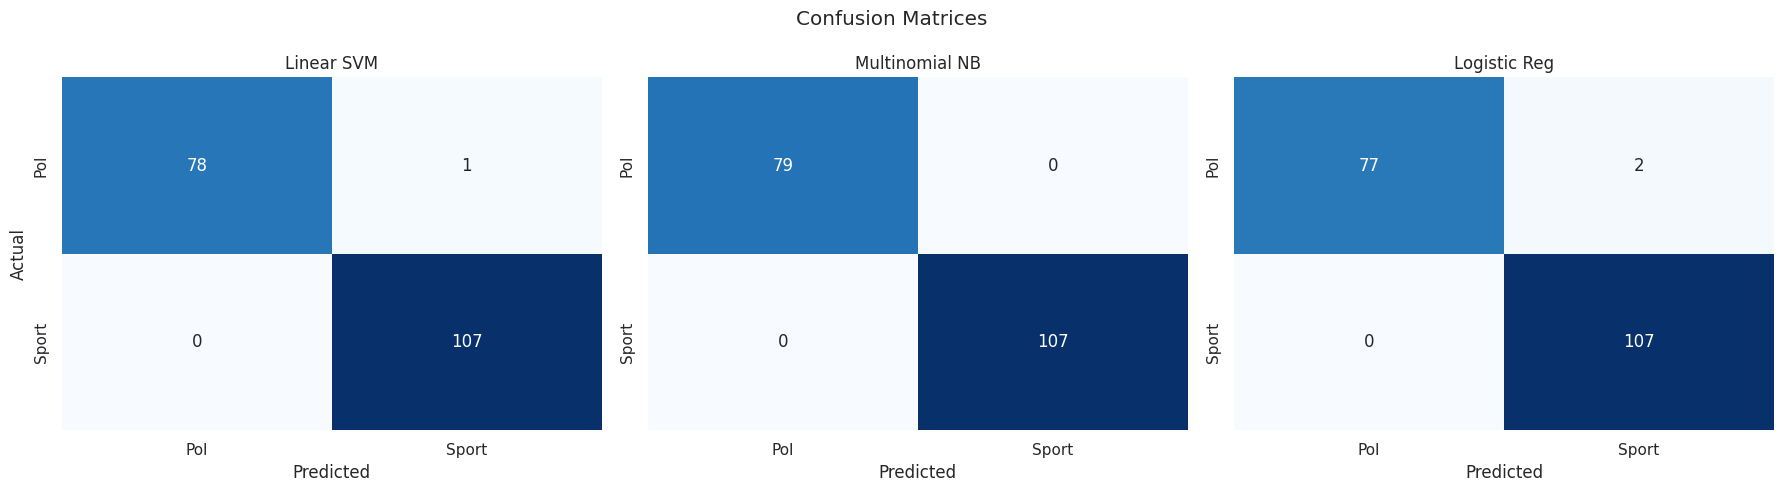

In [12]:
# Visualizations
sns.set_theme(style="whitegrid")

#  plot for accuracy
plt.figure(figsize=(8, 5))

ax = sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0.90, 1.01)

# put numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Confusion Matrices")


for i, (name, model) in enumerate(trained_models.items()):
    preds = model.predict(X_test_vec)
    cm = confusion_matrix(y_test, preds)


    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i],
                xticklabels=["Pol", "Sport"], yticklabels=["Pol", "Sport"], cbar=False)

    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    if i == 0: axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()